In [ ]:
# Use the entire width of the screen if needed
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

---

Here is a good resource explaining the details of choosing t and C for the Hamiltonian Simulation and the controlled rotation respectively.

https://quantumcomputing.com/strangeworks/harrow-hassidim-lloyd-hhl-algorithm

---

In [92]:
# Reset the kernel if needed

%reset -f

In [93]:
# import the relevant libraries etc.
# set up the environment

from qiskit import *
import numpy as np


%matplotlib inline


In [94]:
# Define the problem (the tridiagonal matrix that we are interested in solving)

a = 1
b = 1/2

# Problem size
n_w = 5

In [95]:
# Define the eigenvalue register
n_l = 4

In [96]:
# Define the Trotterization
m = 1
# The order of the Trotter formula that we are using (shoot for the moon)

# Define the number of time steps we are taking
n_t = 10
t = 1
dt = t/n_t

In [97]:
# Define the registers for the problem
work_register = QuantumRegister(n_w,name='work')
eigenvalue_register = QuantumRegister(n_l,name='eignvalue')
ancilla = AncillaRegister(1,name='controlled_rotation')


In [98]:
# Define the initial state of the system
# Implement this later after the unitary of the system is shown to be working fine



In [99]:
# Make a seperate circuit for the unitary, later turn this whole thing into a circuit and 
# apply controlled versions of this

unitary_circuit = QuantumCircuit(work_register,name='U')

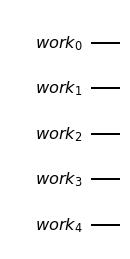

In [100]:
unitary_circuit.draw(output='mpl')

In [101]:
# Make seperate circuits for the different pieces H1 H2 etc

H1_circuit = QuantumCircuit(work_register,name='H1')

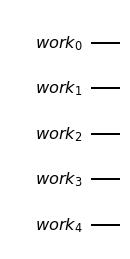

In [102]:
H1_circuit.draw(output='mpl')

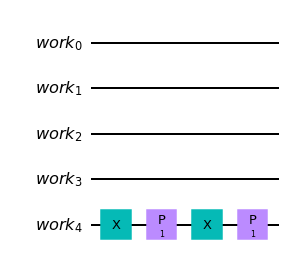

In [103]:
H1_circuit.x(n_w-1)
H1_circuit.p(a*t,n_w-1)
H1_circuit.x(n_w-1)
H1_circuit.p(a*t,n_w-1)
H1_circuit.draw(output='mpl')


In [104]:
H2_circuit = QuantumCircuit(work_register,name='H2')

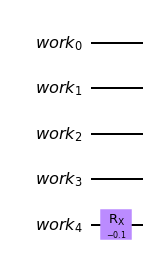

In [105]:
H2_circuit.rx(-2*b*dt,n_w-1)
H2_circuit.draw(output='mpl')

In [106]:
H3_circuit = QuantumCircuit(work_register,name='H3')

In [107]:
# H3 is made up of a bunch of C circuits

C_circuits = []

for _C in range(1,n_w):
    _C_circuit = QuantumCircuit(work_register[-1-_C:],name='C{}'.format(_C))
    _C_circuit.cnot(1,0,ctrl_state=1)
    for _target in range(2,_C+1):
        _C_circuit.cnot(1,_target,ctrl_state=0)
    # Create the multi controlled Rx gate
    #if (_C-2)>=1:
    #    _rx_gate = RXGate(-2*b*dt).control(_C-2)
    #    _C_circuit.append(_rx_gate,[])
        
    
    for _target in reversed(range(2,_C+1)):
        _C_circuit.cnot(1,_target,ctrl_state=0)
    _C_circuit.cnot(1,0,ctrl_state=1)
    C_circuits.append(_C_circuit)


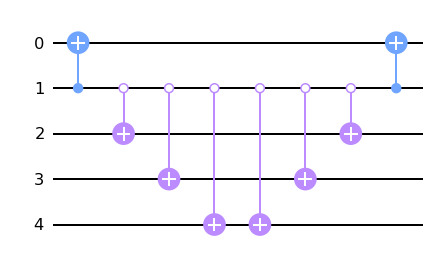

In [108]:
C_circuits[3].draw(output='mpl')